In [85]:
import qiskit
from qiskit import QuantumCircuit
import numpy as np
from qiskit.circuit import Parameter
from qiskit.quantum_info import Statevector
from qiskit.result import Counts, Result
from typing import Optional, List, Dict, Tuple, Union
from matplotlib import pyplot as plt
import itertools
import copy

### Imports that relevant only if molecular structures are calculated
if you have already have list of paulis at hand, you don't need those imports

In [28]:
from qiskit_nature.drivers import UnitsType, Molecule
from qiskit_nature.drivers.second_quantization import (
    ElectronicStructureDriverType,
    ElectronicStructureMoleculeDriver,
)
from qiskit_nature.problems.second_quantization import ElectronicStructureProblem
from qiskit_nature.converters.second_quantization import QubitConverter
from qiskit_nature.mappers.second_quantization import JordanWignerMapper, ParityMapper, BravyiKitaevMapper
from qiskit_nature.transformers.second_quantization.electronic import FreezeCoreTransformer, ActiveSpaceTransformer
# Solvers
from qiskit.algorithms import NumPyMinimumEigensolver
from qiskit_nature.algorithms import GroundStateEigensolver

# for HF calculation
from pyscf import scf
from pyscf import gto

# Functions to calculate expectation values

In [3]:
# define relevant functions
def expval_with_variance(counts,
                         operator_coeff: int,
                         diagonal: Optional[np.ndarray] = None,
                        finite_sampling=True) -> Tuple[float, float]:
    r"""Compute the expectation value of a diagonal operator from counts.

    Args:
        counts: counts object.
        diagonal: Optional, values of the diagonal observable. If None the
                  observable is set to :math:`Z^\otimes n`.

    Returns:
        (float, float): the expectation value and variance.
    """
    if finite_sampling:
        # Get counts shots and probabilities
        probs = np.array(list(counts.values()))
        shots = probs.sum()
        probs = probs / shots
        
        # Get diagonal operator coefficients
        if diagonal is None:
            coeffs = np.array([(-1) ** (key.count('1') % 2)
                               for key in counts.keys()])
        else:
            keys = [int(key, 2) for key in counts.keys()]
            coeffs = np.asarray(diagonal[keys])
            
        # Compute expval
        expval = coeffs.dot(probs)
        
        # Compute variance
        if diagonal is None:
            # The square of the parity diagonal is the all 1 vector
            sq_expval = np.sum(probs)
        else:
            sq_expval = (coeffs ** 2).dot(probs)
        variance = (sq_expval - expval ** 2) / shots
    else:
        probs = counts

        # Get diagonal operator coefficients
        if diagonal is None:
            coeffs = np.array([(-1) ** (key.count('1') % 2)
                               for key in probs.keys()])
        else:
            keys = [int(key, 2) for key in probs.keys()]
            coeffs = np.asarray(diagonal[keys])

        # Compute expval
        expval = coeffs.dot(list(probs.values()))

        # Compute variance
        if diagonal is None:
            # The square of the parity diagonal is the all 1 vector
            sq_expval = np.sum(list(probs.values()))
        else:
            sq_expval = (coeffs ** 2).dot(list(probs.values()))
        variance = (sq_expval - expval ** 2)# / shots

    # Compute standard deviation
    if variance < 0:
        if not np.isclose(variance, 0):
            logger.warning(
                'Encountered a negative variance in expectation value calculation.'
                '(%f). Setting standard deviation of result to 0.', variance)
        variance = 0.0
    return expval * operator_coeff, variance * abs(operator_coeff) ** 2

def calculate_accumulate_exp_val(probs, coeffs, finite_sampling):
    combined_expval = 0.0
    combined_variance = 0.0
    if type(probs) != list:
        probs = [probs]
    for ind, result in enumerate(probs):
        exp_val, exp_var = expval_with_variance(result, coeffs[ind], finite_sampling=finite_sampling)
        # Accumulate
        combined_expval += exp_val
        combined_variance += exp_var
    combined_stddev = np.sqrt(combined_variance)
    return combined_expval, combined_stddev

In [4]:
from qiskit.result import marginal_counts
hadamard = (1 / np.sqrt(2)) * np.array([[1,1],[1,-1]])
s_dg = np.array([[1,0],[0,1j]])
identity = np.array([[1,0],[0,1]])

def evaluate_energy(A_mat, B_mat, paulis, coeffs, MUB_qubits=[0,1], total_qubits=2, shots=None):
    circuit = QuantumCircuit(total_qubits)
    if len(MUB_qubits) == 2:
        prep_MUB_2q(circuit, A_mat, B_mat, MUB_qubits)
    else:
        # for now, we support only 2 and 3 qubit MUBS
        prep_MUB_3q(circuit, A_mat, B_mat, MUB_qubits)
    state = Statevector.from_instruction(circuit)
#     density_matrix = qiskit.quantum_info.DensityMatrix(state)

    # apply rotations to the result state
    results = [] 
    for pauli in paulis:
        measure_op = 1
        marginal_qubits = list(range(total_qubits))
        qubits_to_marginalize_out = []
        for i, val in enumerate(reversed(pauli)):
            if val == 'Y':
                cur_measure_op = hadamard @ s_dg
                measure_op = np.kron(cur_measure_op, measure_op)
            if val == 'X':
                cur_measure_op = hadamard
                measure_op = np.kron(cur_measure_op, measure_op)
            if val == 'Z':
                cur_measure_op = identity
                measure_op = np.kron(cur_measure_op, measure_op)
            if val == 'I': # we calculate expectation value, so we do not need to measure the identity
                cur_measure_op = identity
                measure_op = np.kron(cur_measure_op, measure_op)
                qubits_to_marginalize_out.append(i)

        measured_state = state.evolve(measure_op)

        if shots is not None:
            counts = measured_state.sample_counts(shots)
            if qubits_to_marginalize_out:
                for qubit in qubits_to_marginalize_out:
                    marginal_qubits.remove(qubit)
                counts = marginal_counts(counts, marginal_qubits)
            results.append(counts)
            finite_sampling = True
        else:
            probs = measured_state.probabilities_dict()
            if qubits_to_marginalize_out:
                for qubit in qubits_to_marginalize_out:
                    marginal_qubits.remove(qubit)
                probs = marginal_counts(probs, marginal_qubits)
            results.append(probs)
            finite_sampling=False
    
    expval, stddev = calculate_accumulate_exp_val(results, coeffs, finite_sampling)
    return expval, stddev

# Functions to build the molecular parameters

In [5]:
def get_qubit_op_H2(dist, mapper="parity"):
    molecule = Molecule(geometry=[["H", [0.0, 0.0, 0.0]], ["H", [0.0, 0.0, dist]]], charge=0, multiplicity=1)
    driver = ElectronicStructureMoleculeDriver(
        molecule, basis="sto6g", driver_type=ElectronicStructureDriverType.PYSCF)
    es_problem = ElectronicStructureProblem(driver)
    second_q_op = es_problem.second_q_ops()
    if mapper == "parity":
        qubit_converter = QubitConverter(mapper=ParityMapper(), two_qubit_reduction=True)
    elif mapper == "jordan":
        qubit_converter = QubitConverter(mapper=JordanWignerMapper(), two_qubit_reduction=True)
    elif mapper == "bravi":
        qubit_converter = QubitConverter(mapper=BravyiKitaevMapper(), two_qubit_reduction=True)
    else:
        print("mapper should be one of parity, jordan or bravi")
        return None
    qubit_op = qubit_converter.convert(second_q_op[0], num_particles=es_problem.num_particles)
    return qubit_op, es_problem

In [6]:
def get_hf_energy_H2(dist):
    temp_mol = gto.M(atom = 'H 0 0 0; H 0 0 ' + str(dist), basis = 'sto6g')
    temp_hf = scf.HF(temp_mol)
    return temp_hf.kernel()

In [7]:
def get_exact_energies(elec_struct_prob):
    numpy_solver = NumPyMinimumEigensolver()
    qubit_converter = QubitConverter(mapper=ParityMapper(), two_qubit_reduction=True)
    calc = GroundStateEigensolver(qubit_converter, numpy_solver)
    temp_res = calc.solve(elec_struct_prob)
    return temp_res, temp_res.total_energies[0], temp_res.nuclear_repulsion_energy

In [8]:
def get_paulis_and_coeffs(qubit_op):
    paulis = []
    for op in qubit_op:
        paulis.append(str(op)[-op.num_qubits:])
    return paulis, qubit_op.coeffs

In [22]:
def get_qubit_op_heh(dist, mapper="parity"):
    molecule = Molecule(geometry=[["He", [0.0, 0.0, 0.0]], ["H", [0.0, 0.0, dist]]], charge=1, multiplicity=1)
    driver = ElectronicStructureMoleculeDriver(
        molecule, basis="sto3g", driver_type=ElectronicStructureDriverType.PYSCF)
    es_problem = ElectronicStructureProblem(driver)
    second_q_op = es_problem.second_q_ops()
    if mapper == "parity":
        qubit_converter = QubitConverter(mapper=ParityMapper(), two_qubit_reduction=True)
    elif mapper == "jordan":
        qubit_converter = QubitConverter(mapper=JordanWignerMapper(), two_qubit_reduction=True)
    elif mapper == "bravi":
        qubit_converter = QubitConverter(mapper=BravyiKitaevMapper(), two_qubit_reduction=True)
    else:
        print("mapper should be one of parity, jordan or bravi")
        return None
    qubit_op = qubit_converter.convert(second_q_op[0], num_particles=es_problem.num_particles)
    return qubit_op, es_problem

In [25]:
def get_qubit_op_lih(dist, mapper="parity"):
    molecule = Molecule(geometry=[["Li", [0.0, 0.0, 0.0]], ["H", [0.0, 0.0, dist]]], charge=0, multiplicity=1)
    driver = ElectronicStructureMoleculeDriver(
        molecule, basis="sto3g", driver_type=ElectronicStructureDriverType.PYSCF)
    es_problem = ElectronicStructureProblem(driver, 
                                            transformers=[ActiveSpaceTransformer(num_electrons=2, 
                                                                                 num_molecular_orbitals=3,
                                                                                active_orbitals=[1,2,5])])
    second_q_op = es_problem.second_q_ops()
    if mapper == "parity":
        qubit_converter = QubitConverter(mapper=ParityMapper(), two_qubit_reduction=True)
    elif mapper == "jordan":
        qubit_converter = QubitConverter(mapper=JordanWignerMapper(), two_qubit_reduction=True)
    elif mapper == "bravi":
        qubit_converter = QubitConverter(mapper=BravyiKitaevMapper(), two_qubit_reduction=True)
    else:
        print("mapper should be one of parity, jordan or bravi")
        return None
    qubit_op = qubit_converter.convert(second_q_op[0], num_particles=es_problem.num_particles)
    return qubit_op, es_problem

# MUB preperation

In [9]:
# Adds Y-Hadamard gate on qubit q in circ
def yh(circ, q):
    circ.h(q)
    circ.s(q)

def prep_MUB_2q(circ, A_mat, B_mat, qubits):
    # A_mat chooses the state in the basis (MUB)
    if A_mat == 1:
        circ.x(qubits[0])
    elif A_mat == 2:
        circ.x(qubits[1])
    elif A_mat == 3:
        circ.x(qubits[0])
        circ.x(qubits[1])
        
    # B_mat chooses the basis (MUB) itself
    if B_mat == 1:
        circ.h(qubits[0])
        circ.h(qubits[1])
    elif B_mat == 2:
        circ.h(qubits[0])
        yh(circ,qubits[1])
        circ.cz(qubits[0], qubits[1])
    elif B_mat == 3:
        yh(circ,qubits[0])
        yh(circ,qubits[1])
    elif B_mat == 4:
        yh(circ,qubits[0])
        circ.h(qubits[1])
        circ.cz(qubits[0], qubits[1])
        
def prep_MUB_3q(circ, A_mat, B_mat, qubits):
    # A_mat chooses the state in the basis (MUB)
    if A_mat == 1:
        circ.x(qubits[0])
    elif A_mat == 2:
        circ.x(qubits[1])
    elif A_mat == 3:
        circ.x(qubits[0])
        circ.x(qubits[1])
    elif A_mat == 4:
        circ.x(qubits[2])
    elif A_mat == 5:
        circ.x(qubits[0])
        circ.x(qubits[2])
    elif A_mat == 6:
        circ.x(qubits[1])
        circ.x(qubits[2])
    elif A_mat == 7:
        circ.x(qubits[0])
        circ.x(qubits[1])
        circ.x(qubits[2])
    
    # B_mat chooses the basis (MUB) itself
    if B_mat == 1:
        circ.h(qubits[0])
        circ.h(qubits[1])
        circ.h(qubits[2])
    elif B_mat == 2:
        yh(circ, qubits[0])
        yh(circ, qubits[1])
        yh(circ, qubits[2])
    elif B_mat == 3:
        yh(circ, qubits[0])
        circ.h(qubits[1])
        circ.h(qubits[2])
        circ.cz(qubits[1], qubits[2])
        circ.cz(qubits[0], qubits[1])
    elif B_mat == 4:
        circ.h(qubits[0])
        yh(circ, qubits[1])
        circ.h(qubits[2])
        circ.cz(qubits[1], qubits[2])
        circ.cz(qubits[0], qubits[2])
    elif B_mat == 5:
        circ.h(qubits[0])
        circ.h(qubits[1])
        yh(circ, qubits[2])
        circ.cz(qubits[0], qubits[1])
        circ.cz(qubits[0], qubits[2])
    elif B_mat == 6:
        yh(circ, qubits[0])
        yh(circ, qubits[1])
        circ.h(qubits[2])
        circ.cz(qubits[0], qubits[1])
        circ.cz(qubits[0], qubits[2])
    elif B_mat == 7:
        yh(circ, qubits[0])
        circ.h(qubits[1])
        yh(circ, qubits[2])
        circ.cz(qubits[1], qubits[2])
        circ.cz(qubits[0], qubits[2])
    elif B_mat == 8:
        circ.h(qubits[0])
        yh(circ, qubits[1])
        yh(circ, qubits[2])
        circ.cz(qubits[0], qubits[1])
        circ.cz(qubits[1], qubits[2])

# Functions to plot results

In [10]:
def get_indecies(list_of_energies, fisrt_index):
    indices = []
    indices += list(np.array(list_of_energies[fisrt_index::20]))
    indices += list(np.array(list_of_energies[fisrt_index+1::20]))
    indices += list(np.array(list_of_energies[fisrt_index+2::20]))
    indices += list(np.array(list_of_energies[fisrt_index+3::20]))
    indices += list(np.array(list_of_energies[fisrt_index+4::20]))
    return indices

In [11]:
def plot_MUB_energies_5_bases(MUB_energies, exact_value, title):
    x_indexes = np.array(list(range(len(MUB_energies))))
    MUB_energies = np.array(MUB_energies)
    indices_0 = get_indecies(x_indexes, 0)
    indices_1 = get_indecies(x_indexes, 4)
    indices_2 = get_indecies(x_indexes, 8)
    indices_3 = get_indecies(x_indexes, 12)
    indices_4 = get_indecies(x_indexes, 16)

    fig = plt.figure(figsize=(8, 5))
    plt.plot(x_indexes[indices_0], MUB_energies[indices_0] , 'o', lw=3, label="MUB energy, basis 0")
    plt.plot(x_indexes[indices_1], MUB_energies[indices_1] , 'o', lw=3, label="MUB energy, basis 1")
    plt.plot(x_indexes[indices_2], MUB_energies[indices_2] , 'o', lw=3, label="MUB energy, basis 2")
    plt.plot(x_indexes[indices_3], MUB_energies[indices_3] , 'o', lw=3, label="MUB energy, basis 3")
    plt.plot(x_indexes[indices_4], MUB_energies[indices_4] , 'o', lw=3, label="MUB energy, basis 4")
    plt.plot(x_indexes, [exact_value] * len(x_indexes) , 'k', 
             lw=3, label="subspace FCI energy", linestyle="dashed")
    plt.xlabel("MUB index")
    plt.ylabel("Energy [Hartree]")
    plt.legend(frameon=False)
    plt.title(title)
    plt.show()

In [20]:
def plot_MUB_energies_with_hf(MUB_energies, exact_value, hf_value, title):
    x_indexes = list(range(len(MUB_energies)))

    fig = plt.figure(figsize=(8, 5))
    plt.plot(x_indexes, MUB_energies , lw=3, label="MUB energy")
    plt.plot(x_indexes, [exact_value] * len(x_indexes) , 'k', 
             lw=3, label="exact energy", linestyle="dashed")
    plt.plot(x_indexes, [hf_value] * len(x_indexes) ,color='#089FFF', 
             lw=3, label="hartree fock energy", linestyle="dashed")
    plt.xlabel("MUB index")
    plt.ylabel("Energy")
    plt.legend(frameon=False)
    plt.title(title)
    plt.show()

# Functions to calculate the energy surface for the MUB states

In [13]:
def calculate_MUBs_2qubits_pair_list(model_qubit_num):
    pair_list = []
    for elem in itertools.combinations(np.linspace(0, model_qubit_num-1, model_qubit_num, dtype=int), 2):
        pair_list.append(elem)
    return pair_list

In [30]:
def calculate_enegies_for_MUBs(mol_build_func, dist, num_of_qubits=2):
    """
    runs over all bases and states for each combination of 2 qubit MUBs
    (keeps the rest of the qubits in the ground state)
    """
    qubit_op, es_problem = mol_build_func(dist)
    exact_res, exact_energy, nuclear_repulsion_energy = get_exact_energies(es_problem)
    transform_energy = exact_res.extracted_transformer_energy
    paulis, coeffs = get_paulis_and_coeffs(qubit_op)
    
    pair_list = calculate_MUBs_2qubits_pair_list(num_of_qubits)
            
    MUBs_2qubits = []
    for mapping in pair_list:
        MUBs_2qubits_cur_map = []
        for mat_b in range(5):
            MUBs_2qubits_cur_map.append([])
            for mat_a in range(4):
                # don't simulate the first pauli, as it is always the identity, so just add it coeff to the energy
                MUB_energy, _ = evaluate_energy(mat_a, mat_b, paulis[1:], coeffs[1:], mapping, 
                                                total_qubits=num_of_qubits)
                MUBs_2qubits_cur_map[-1].append(MUB_energy.real + coeffs[0] + 
                                                nuclear_repulsion_energy + transform_energy)
        MUBs_2qubits.append(MUBs_2qubits_cur_map)
    return MUBs_2qubits, exact_energy

In [15]:
def flatten_results_array(MUBs_2qubits):
    all_MUBs_2qubit_energies = []
    for mapping in MUBs_2qubits:
        for MUB_basis in mapping:
            for MUB_element in MUB_basis:
                all_MUBs_2qubit_energies.append(MUB_element.real)
    return all_MUBs_2qubit_energies

# Calculate the energy for MUB states for H2 at r=0.75

In [16]:
MUBs_2qubits_H2, exact_energy_H2 = calculate_enegies_for_MUBs(get_qubit_op_H2, 0.75)
all_MUBs_2qubit_energies_H2 = flatten_results_array(MUBs_2qubits_H2)

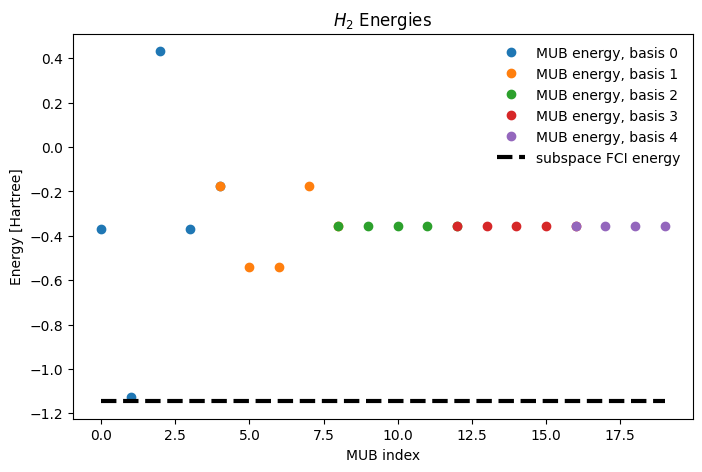

In [17]:
plot_MUB_energies_5_bases(all_MUBs_2qubit_energies_H2, exact_energy_H2, "$H_2$ Energies")

compare also to Hartree-Fock

In [18]:
hf_energy_H2 = get_hf_energy_H2(0.75)

converged SCF energy = -1.1247307455369


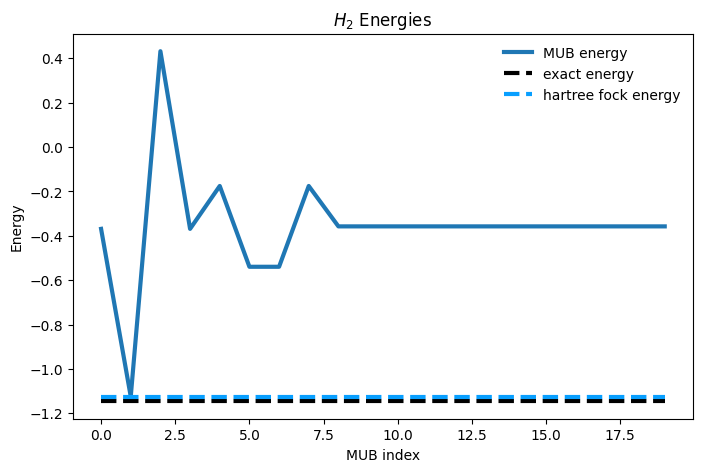

In [21]:
plot_MUB_energies_with_hf(all_MUBs_2qubit_energies_H2, exact_energy_H2, hf_energy_H2, "$H_2$ Energies")

# Calculate the energy for MUB states for $HeH^+$ at r=1

In [23]:
MUBs_2qubits_HeH, exact_energy_HeH = calculate_enegies_for_MUBs(get_qubit_op_heh, 1)
all_MUBs_2qubit_energies_HeH = flatten_results_array(MUBs_2qubits_HeH)

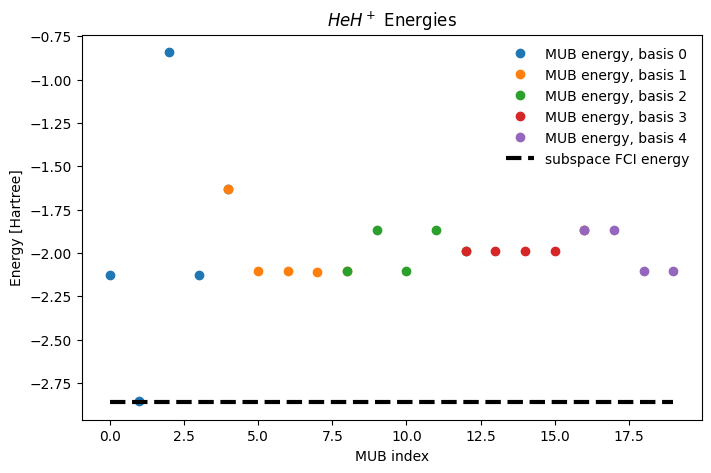

In [24]:
plot_MUB_energies_5_bases(all_MUBs_2qubit_energies_HeH, exact_energy_HeH, "$HeH^+$ Energies")

# Calculate the energy for MUB states for $LiH$ at r=1.5

In [31]:
MUBs_2qubits_LiH, exact_energy_LiH = calculate_enegies_for_MUBs(get_qubit_op_lih, 1.5, 4)
all_MUBs_2qubit_energies_LiH = flatten_results_array(MUBs_2qubits_LiH)

/Users/dekelmeirom/opt/anaconda3/envs/quantum/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


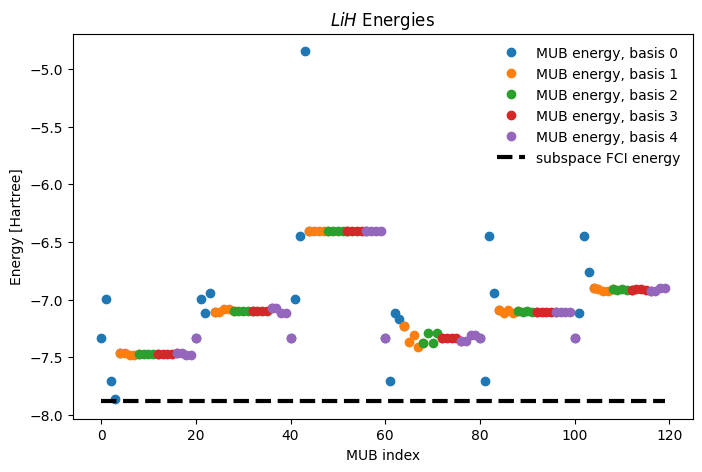

In [32]:
plot_MUB_energies_5_bases(all_MUBs_2qubit_energies_LiH, exact_energy_LiH, "$LiH$ Energies")

# VQE optimization starting from MUB states

## parameters to create MUBS
parameters to 2 qubits MUBs using the CX ansatz format
#### computational basis
[1, 0, 0, 0] - theta = [0, 0, 0, 0, 0, 0, 0, 0]

[0, 1, 0, 0] - theta = [0, 0, 0, 0, $\pi$, 0, 0, 0]

[0, 0, 1, 0] - theta = [0, 0, 0, 0, 0, $\pi$, 0, 0]

[0, 0, 0, 1] - theta = [0, 0, 0, 0, $\pi$, $\pi$, 0, 0]
#### M1
$\frac{1}{2}\cdot$[1, 1, 1, 1] -   theta = [0, 0, 0, 0, $\frac{\pi}{2}$, $\frac{\pi}{2}$, 0, 0]

$\frac{1}{2}\cdot$[1, 1, -1, -1] - theta = [0, $-\pi$, 0, 0, $\frac{\pi}{2}$, $\frac{\pi}{2}$, 0, 0]

$\frac{1}{2}\cdot$[1, -1, -1, 1] - theta = [$\pi$, 0, 0, 0, $\frac{\pi}{2}$, $\frac{\pi}{2}$, 0, 0]

$\frac{1}{2}\cdot$[1, -1, 1, -1] - theta = [$\pi$, $-\pi$, 0, 0, $\frac{\pi}{2}$, $\frac{\pi}{2}$, 0, 0]

#### M2
$\frac{1}{2}\cdot$[1, -1, -i, -i] -   theta = [$\frac{\pi}{2}$, $-\frac{\pi}{2}$, $-\frac{\pi}{2}$, $\frac{\pi}{2}$, 0, 0, 0, 0]

$\frac{1}{2}\cdot$[1, -1, i, i] - theta = [$-\frac{\pi}{2}$, $\frac{\pi}{2}$, $-\frac{\pi}{2}$, $\frac{\pi}{2}$, 0, 0, 0, 0]

$\frac{1}{2}\cdot$[1, 1, i, -i] - theta = [$\frac{\pi}{2}$, $\frac{\pi}{2}$, $-\frac{\pi}{2}$, $\frac{\pi}{2}$, 0, 0, 0, 0]

$\frac{1}{2}\cdot$[1, 1, -i, i] - theta = [$-\frac{\pi}{2}$, $-\frac{\pi}{2}$, $-\frac{\pi}{2}$, $\frac{\pi}{2}$, 0, 0, 0, 0]

#### M3
$\frac{1}{2}\cdot$[1, -i, -i, -1] -   theta = [0, 0, $\frac{\pi}{2}$, $\frac{\pi}{2}$, $\frac{\pi}{2}$, $\frac{\pi}{2}$, $ -\frac{\pi}{2}$, $-\frac{\pi}{2}$]

$\frac{1}{2}\cdot$[1, -i, i, 1] - theta = [0, 0, $\frac{\pi}{2}$, $\frac{\pi}{2}$, $\frac{\pi}{2}$, $-\frac{\pi}{2}$, $ -\frac{\pi}{2}$, $-\frac{\pi}{2}$]

$\frac{1}{2}\cdot$[1, i, i, -1] - theta = [0, 0, $-\frac{\pi}{2}$, $-\frac{\pi}{2}$, $\frac{\pi}{2}$, $\frac{\pi}{2}$, $\frac{\pi}{2}$, $\frac{\pi}{2}$]

$\frac{1}{2}\cdot$[1, i, -i, 1] - theta = [0, 0, $-\frac{\pi}{2}$, $-\frac{\pi}{2}$, $\frac{\pi}{2}$, $-\frac{\pi}{2}$, $\frac{\pi}{2}$, $\frac{\pi}{2}$]

#### M4
$\frac{1}{2}\cdot$[1, -i, -1, -i] -   theta = [$\frac{\pi}{2}$, $-\frac{\pi}{2}$, $\frac{\pi}{2}$, $\frac{\pi}{2}$, $\frac{\pi}{2}$, $\frac{\pi}{2}$, 0, 0]

$\frac{1}{2}\cdot$[1, -i, 1, i] - theta = [$-\frac{\pi}{2}$, $\frac{\pi}{2}$, $-\frac{\pi}{2}$, $\frac{\pi}{2}$, $\frac{\pi}{2}$, $\frac{\pi}{2}$, 0, 0]

$\frac{1}{2}\cdot$[1, i, -1, i] - theta = [$\frac{\pi}{2}$, $-\frac{\pi}{2}$, $-\frac{\pi}{2}$, $-\frac{\pi}{2}$, $\frac{\pi}{2}$, $\frac{\pi}{2}$, 0, 0]

$\frac{1}{2}\cdot$[1, i, 1, -i] - theta = [$\frac{\pi}{2}$, $-\frac{\pi}{2}$, $-\frac{\pi}{2}$, $\frac{\pi}{2}$, $\frac{\pi}{2}$, $\frac{\pi}{2}$, 0, 0]

In [34]:
def ansatz_hardware_efficient_2qubits(circ, theta, qubits):
    circ.ry(theta[0], qubits[0])
    circ.ry(theta[1], qubits[1])
    circ.rz(theta[2], qubits[0])
    circ.rz(theta[3], qubits[1])
    circ.cx(qubits[0], qubits[1])
    circ.ry(theta[4], qubits[0])
    circ.ry(theta[5], qubits[1])
    circ.rz(theta[6], qubits[0])
    circ.rz(theta[7], qubits[1])
    return circ

In [35]:
def params_MUB_2q(A_mat, B_mat):
    # A_mat chooses the state in the basis (MUB)
    # B_mat chooses the basis (MUB) itself
    if B_mat == 0:
        if A_mat == 0:
            return [0, 0, 0, 0, 0, 0, 0, 0]
        elif A_mat == 1:
            return [0, 0, 0, 0, np.pi, 0, 0, 0]
        elif A_mat == 2:
            return [0, 0, 0, 0, 0, np.pi, 0, 0]
        elif A_mat == 3:
            return [0, 0, 0, 0, np.pi, np.pi, 0, 0]
    if B_mat == 1:
        if A_mat == 0:
            return [0, 0, 0, 0, np.pi / 2, np.pi / 2, 0, 0]
        elif A_mat == 1:
            return [0, -np.pi, 0, 0, np.pi / 2, np.pi / 2, 0, 0]
        elif A_mat == 2:
            return [np.pi, 0, 0, 0, np.pi / 2, np.pi / 2, 0, 0]
        elif A_mat == 3:
            return [np.pi, -np.pi, 0, 0, np.pi / 2, np.pi / 2, 0, 0]
    elif B_mat == 2:
        if A_mat == 0:
            return [np.pi / 2, -np.pi / 2, -np.pi/2, np.pi/2, 0, 0, 0, 0]
        elif A_mat == 1:
            return [-np.pi / 2, np.pi / 2, -np.pi/2, np.pi/2, 0, 0, 0, 0]
        elif A_mat == 2:
            return [np.pi / 2, np.pi / 2, -np.pi/2, np.pi/2, 0, 0, 0, 0]
        elif A_mat == 3:
            return [-np.pi / 2, -np.pi / 2, -np.pi/2, np.pi/2, 0, 0, 0, 0]
    elif B_mat == 3:
        if A_mat == 0:
            return [0, 0, np.pi/2, np.pi/2, np.pi/2, np.pi/2, -np.pi/2, -np.pi/2]
        elif A_mat == 1:
            return [0, 0, np.pi/2, np.pi/2, np.pi/2, -np.pi/2, -np.pi/2, -np.pi/2]
        elif A_mat == 2:
            return [0, 0, -np.pi/2, -np.pi/2, np.pi/2, np.pi/2, np.pi/2, np.pi/2]
        elif A_mat == 3:
            return [0, 0, -np.pi/2, -np.pi/2, np.pi/2, -np.pi/2, np.pi/2, np.pi/2]
    elif B_mat == 4:
        if A_mat == 0:
            return [np.pi/2, -np.pi/2, np.pi/2, np.pi/2, np.pi/2, np.pi/2, 0, 0]
        elif A_mat == 1:
            return [-np.pi/2, np.pi/2, -np.pi/2, np.pi/2, np.pi/2, np.pi/2, 0, 0]
        elif A_mat == 2:
            return [np.pi/2, -np.pi/2, -np.pi/2, -np.pi/2, np.pi/2, np.pi/2, 0, 0]
        elif A_mat == 3:
            return [np.pi/2, -np.pi/2, -np.pi/2, np.pi/2, np.pi/2, np.pi/2, 0, 0]

In [79]:
from qiskit.result import marginal_counts
hadamard = (1 / np.sqrt(2)) * np.array([[1,1],[1,-1]])
s_dg = np.array([[1,0],[0,1j]])
identity = np.array([[1,0],[0,1]])

def evaluate_energy(theta, paulis, coeffs, qubits=[0,1], shots=None):
    total_qubits = len(qubits)
    init_circuit = QuantumCircuit(total_qubits, total_qubits)
    circuit = ansatz_hardware_efficient_2qubits(init_circuit, theta, qubits)
    ansatz_state = Statevector.from_instruction(circuit)

    # apply rotations to the result state
    results = [] 
    for pauli in paulis:
        measure_op = 1
        marginal_qubits = list(range(total_qubits))
        qubits_to_marginalize_out = []
        for i, val in enumerate(reversed(pauli)):
            if val == 'Y':
                cur_measure_op = hadamard @ s_dg
                measure_op = np.kron(cur_measure_op, measure_op)
            if val == 'X':
                cur_measure_op = hadamard
                measure_op = np.kron(cur_measure_op, measure_op)
            if val == 'Z':
                cur_measure_op = identity
                measure_op = np.kron(cur_measure_op, measure_op)
            if val == 'I': # we calculate expectation value, so we do not need to measure the identity
                cur_measure_op = identity
                measure_op = np.kron(cur_measure_op, measure_op)
                qubits_to_marginalize_out.append(i)

        measured_state = ansatz_state.evolve(measure_op)

        if shots is not None:
            counts = measured_state.sample_counts(shots)
            if qubits_to_marginalize_out:
                for qubit in qubits_to_marginalize_out:
                    marginal_qubits.remove(qubit)
                counts = marginal_counts(counts, marginal_qubits)
            results.append(counts)
            finite_sampling = True
        else:
            probs = measured_state.probabilities_dict()
            if qubits_to_marginalize_out:
                for qubit in qubits_to_marginalize_out:
                    marginal_qubits.remove(qubit)
                probs = marginal_counts(probs, marginal_qubits)
            results.append(probs)
            finite_sampling=False
    
    expval, stddev = calculate_accumulate_exp_val(results, coeffs, finite_sampling)
    # save in global variables the mid-optimization values
    thetas.append(copy.deepcopy(theta))
    values.append(expval)
    return expval, stddev

In [102]:
def run_VQE(mol_build_func, dist):
    qubit_op, es_problem = mol_build_func(dist)
    exact_res, exact_energy, nuclear_repulsion_energy = get_exact_energies(es_problem)
    transform_energy = exact_res.extracted_transformer_energy
    paulis, coeffs = get_paulis_and_coeffs(qubit_op)

    # pair_list = calculate_MUBs_2qubits_pair_list(2)

    all_thetas = []
    all_values = []
    final_results = []
    for i in range(4):
        A_final_results = []
        A_thetas = []
        A_values = []
        for j in range(5):
            thetas = []
            values = []
            initial_theta = params_MUB_2q(i, j)
            vqe_result = minimize(evaluate_energy,
                                  initial_theta,
                                  args=(paulis[1:], coeffs[1:]), # calculate without the identity pauli
                                  method='COBYLA')
            print("results for A_i = " + str(i) + " and B_j = " + str(j) + ":")
            print("final theta: " + str(vqe_result.x))
            energy_result = vqe_result.fun + coeffs[0] + nuclear_repulsion_energy + transform_energy
            print("min energy value: " + str(energy_result.real))
            A_final_results.append(energy_result)
            # save for parameters space calculations
            A_thetas.append(thetas)
            A_values.append(values)
        final_results.append(A_final_results)
        # save for parameters space calculations
        all_thetas.append(A_thetas)
        all_values.append(A_values)
    return final_results, all_values, all_thetas, exact_energy

In [78]:
from scipy.optimize import minimize

## Run VQE on $H_2$

In [86]:
final_results_H2, all_values_H2, all_thetas_H2, exact_energy_H2 = run_VQE(get_qubit_op_H2, 0.75)

/Users/dekelmeirom/opt/anaconda3/envs/quantum/lib/python3.7/site-packages/scipy/optimize/cobyla.py:262: ComplexWarning: Casting complex values to real discards the imaginary part
  dinfo=info)


results for A_i = 0 and B_j = 0:
final theta: [ 4.79143377e-01  1.05397292e+00 -6.62862750e-04  1.64846982e-04
  2.71750691e+00 -1.10370554e+00  1.86375821e-01  1.87701105e-01]
min energy value: -1.1457416436735044
results for A_i = 0 and B_j = 1:
final theta: [0.23917843 0.2825001  0.23071248 3.12695307 3.20691653 0.28688929
 0.95286451 0.71839416]
min energy value: -1.1457001411462255
results for A_i = 0 and B_j = 2:
final theta: [ 2.91174445e+00 -3.13649140e+00 -1.68226306e+00  3.16050316e+00
 -1.70522558e-04 -5.28309783e-03 -1.77767734e-01  1.28150985e+00]
min energy value: -1.1457414110609934
results for A_i = 0 and B_j = 3:
final theta: [ 2.29794941e-01  2.59500845e-05  9.15440068e-01  1.46183829e+00
  3.14170563e+00  1.74317980e-05 -6.25662516e-01 -1.54087896e+00]
min energy value: -1.1457416677173868
results for A_i = 0 and B_j = 4:
final theta: [ 3.14289446e+00 -1.43922855e+00  1.83821020e+00  3.50102567e-04
 -3.68951712e-04  1.70189264e+00 -8.32228429e-01 -5.81483514e-01]
min

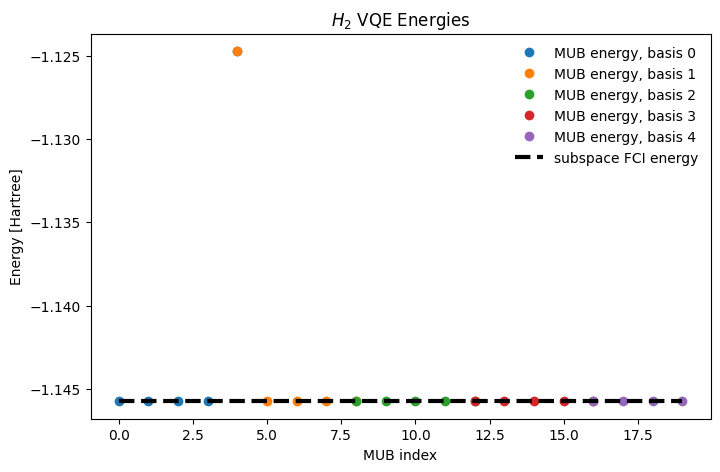

In [105]:
plot_MUB_energies_5_bases(flatten_results_array([final_results_H2]), exact_energy_H2, "$H_2$ VQE Energies")

## Run VQE on $HeH^+$

In [101]:
final_results_HeH, all_values_HeH, all_thetas_HeH, exact_energy_HeH = run_VQE(get_qubit_op_heh, 1)

/Users/dekelmeirom/opt/anaconda3/envs/quantum/lib/python3.7/site-packages/scipy/optimize/cobyla.py:262: ComplexWarning: Casting complex values to real discards the imaginary part
  dinfo=info)


results for A_i = 0 and B_j = 0:
final theta: [ 0.13094694  0.36650715  0.0701779  -0.07568713  3.07396734 -0.34179173
  0.89693848  0.79255299]
min energy value: -2.8600616492344617
results for A_i = 0 and B_j = 1:
final theta: [ 0.19996629 -0.89416696  0.18493807  0.0316593   3.27786797  0.92507129
  1.00303182  0.85039959]
min energy value: -2.860204912413219
results for A_i = 0 and B_j = 2:
final theta: [ 3.26186894 -2.97625067 -1.45656515  3.01308545 -0.02566079 -0.13919418
  0.7319709  -0.74725762]
min energy value: -2.859897161806993
results for A_i = 0 and B_j = 3:
final theta: [ 1.22749953e-01  3.71997061e-02  8.46493658e-01  1.66637197e+00
  3.12050290e+00  5.11760749e-05 -8.37557952e-01 -1.67240500e+00]
min energy value: -2.8601004873635363
results for A_i = 0 and B_j = 4:
final theta: [ 3.01523362e+00 -3.37634520e-01  5.71167660e-01  1.01891368e-03
 -6.12500220e-02  2.83631943e+00 -6.00939248e-01  7.23640300e-03]
min energy value: -2.8599044415985144
results for A_i = 1 and

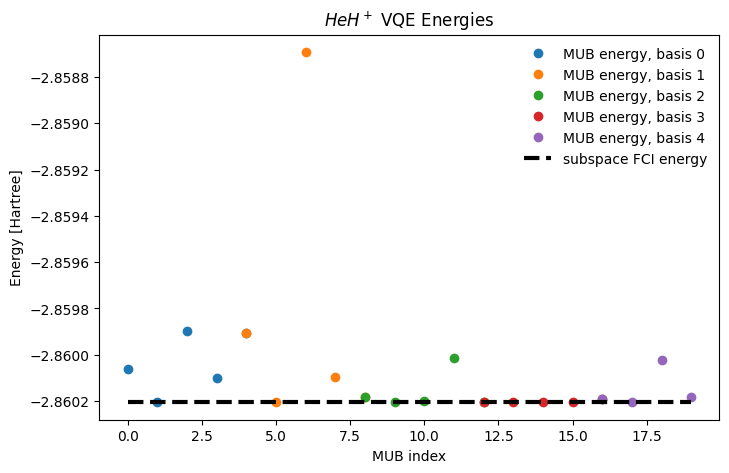

In [104]:
plot_MUB_energies_5_bases(flatten_results_array([final_results_HeH]), exact_energy_HeH, "$HeH^+$ VQE Energies")